In [1]:
!pip install pandas numpy seaborn matplotlib nltk torch transformers neural-tangents scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from transformers import BertTokenizer, BertModel
import torch
import neural_tangents as nt


In [3]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Load the dataset
dataset = pd.read_csv(r"/content/drive/MyDrive/IMDB_Dataset.csv")

dataset = dataset.iloc[:7000]

# Text preprocessing function
def text_preprocessing(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\d', ' ', text)  # Remove digits
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

# Preprocess reviews and convert sentiment to binary
dataset['preprocessed_reviews'] = dataset['review'].apply(text_preprocessing)
dataset['sentiment'] = dataset['sentiment'].apply(lambda sentiment: 1 if sentiment == 'positive' else 0)



In [5]:
# Prepare features and target
X = dataset['preprocessed_reviews']
y = dataset['sentiment']


In [6]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to embed reviews using BERT
def bert_embed_reviews(reviews, batch_size=32):
    embeddings = []
    for i in range(0, len(reviews), batch_size):
        batch = reviews[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

# Convert X to a list of strings
X_list = X.tolist()

# Create embeddings
X_embeddings = bert_embed_reviews(X_list)

In [8]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=45)


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn

Epoch 1, Loss: 0.7419148683547974
Epoch 2, Loss: 0.7389766573905945
Epoch 3, Loss: 0.7362119555473328
Epoch 4, Loss: 0.7336070537567139
Epoch 5, Loss: 0.7311496138572693
Epoch 6, Loss: 0.7288311123847961
Epoch 7, Loss: 0.7266479730606079
Epoch 8, Loss: 0.7246018052101135
Epoch 9, Loss: 0.722697377204895
Epoch 10, Loss: 0.7209421396255493
Epoch 11, Loss: 0.7193437814712524
Epoch 12, Loss: 0.7179089784622192
Epoch 13, Loss: 0.716641902923584
Epoch 14, Loss: 0.7155427932739258
Epoch 15, Loss: 0.7146072387695312
Epoch 16, Loss: 0.7138258814811707
Epoch 17, Loss: 0.7131850719451904
Epoch 18, Loss: 0.7126682996749878
Epoch 19, Loss: 0.7122573256492615
Epoch 20, Loss: 0.7119340896606445
Epoch 21, Loss: 0.711681604385376
Epoch 22, Loss: 0.7114847898483276
Epoch 23, Loss: 0.7113311886787415
Epoch 24, Loss: 0.7112102508544922
Epoch 25, Loss: 0.7111141085624695
Epoch 26, Loss: 0.7110363841056824
Epoch 27, Loss: 0.7109723687171936
Epoch 28, Loss: 0.7109184265136719
Epoch 29, Loss: 0.71087205410003

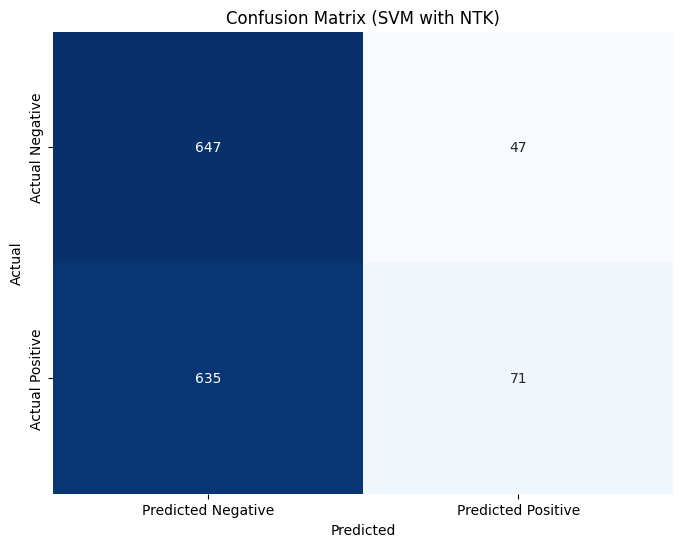

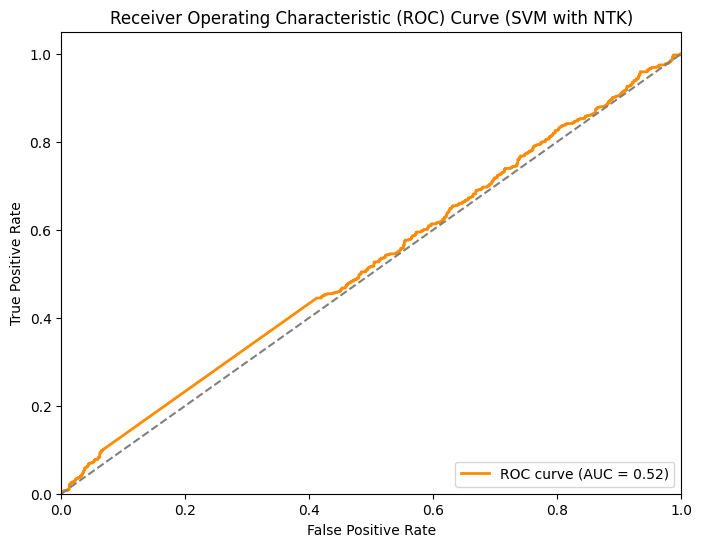

In [11]:
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the Custom MLP model with Flax
class CustomMLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(1024)(x)
        x = nn.gelu(x)
        x = nn.Dropout(0.2)(x, deterministic=False)  # Increased dropout rate for better regularization
        x = nn.Dense(512)(x)
        x = nn.gelu(x)
        x = nn.Dropout(0.2)(x, deterministic=False)
        x = nn.Dense(256)(x)
        x = nn.gelu(x)
        x = nn.Dense(1)(x)
        return nn.sigmoid(x)

# Initialize the model
def initialize_model(rng, input_shape):
    model = CustomMLP()
    variables = model.init(rng, jnp.ones(input_shape))
    return model, variables

# Compute the kernel matrix using the trained neural network
def compute_kernel_matrix(X1, X2, model, params, dropout_rng):
    def compute_output(x):
        return model.apply(params, x, rngs={'dropout': dropout_rng})

    K1 = compute_output(X1)
    K2 = compute_output(X2)
    return jnp.outer(K1, K2)

# Training function
def train_model(X_train, y_train, model, params, learning_rate=0.0001, l2_lambda=1e-5, epochs=10000):
    # Define optimizer and loss function
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    def loss_fn(params, X, y):
        preds = model.apply(params, X, rngs={'dropout': jax.random.PRNGKey(0)})
        l2_loss = l2_lambda * sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
        return jnp.mean(optax.sigmoid_binary_cross_entropy(preds, y)) + l2_loss

    # Training loop
    for epoch in range(1000):
        loss, grads = jax.value_and_grad(loss_fn)(params, X_train, y_train)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        print(f"Epoch {epoch + 1}, Loss: {loss}")

    return params

# Prepare data
X1_tensor = jnp.array(X_train, dtype=jnp.float32)
X2_tensor = jnp.array(X_test, dtype=jnp.float32)
y_train_tensor = jnp.array(y_train[:X_train.shape[0]], dtype=jnp.float32)

# Initialize and train the model
rng = jax.random.PRNGKey(0)
model, params = initialize_model(rng, X1_tensor.shape)
trained_params = train_model(X1_tensor, y_train_tensor, model, params)

# Compute the NTK matrix
ntk_train_matrix = compute_kernel_matrix(X1_tensor, X1_tensor, model, trained_params, rng)
ntk_test_matrix = compute_kernel_matrix(X2_tensor, X1_tensor, model, trained_params, rng)

# Perform SVM with NTK
param_grid_svm_ntk = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['precomputed'],
}

svm_ntk = SVC(class_weight='balanced', probability=True)
grid_search_ntk = GridSearchCV(svm_ntk, param_grid_svm_ntk, refit=True, verbose=2, cv=5)
grid_search_ntk.fit(ntk_train_matrix, y_train)

# Predictions and Evaluation
y_pred_prob_ntk = grid_search_ntk.predict_proba(ntk_test_matrix)[:, 1]
y_pred_ntk = (y_pred_prob_ntk > 0.5).astype(int)

# Metrics
accuracy_ntk = accuracy_score(y_test, y_pred_ntk)
precision_ntk = precision_score(y_test, y_pred_ntk)
recall_ntk = recall_score(y_test, y_pred_ntk)
f1_ntk = f1_score(y_test, y_pred_ntk)

print(f"Accuracy (SVM with NTK): {accuracy_ntk*100:.2f}%")
print(f"Precision: {precision_ntk:.2f}")
print(f"Recall: {recall_ntk:.2f}")
print(f"F1 Score: {f1_ntk:.2f}")

# Confusion Matrix
cm_ntk = confusion_matrix(y_test, y_pred_ntk)
cm_df_ntk = pd.DataFrame(cm_ntk, index=["Actual Negative", "Actual Positive"],
                         columns=["Predicted Negative", "Predicted Positive"])
print("\nConfusion Matrix DataFrame (SVM with NTK):")
print(cm_df_ntk)

# ROC curve and AUC
fpr_ntk, tpr_ntk, _ = roc_curve(y_test, y_pred_prob_ntk)
roc_auc_ntk = auc(fpr_ntk, tpr_ntk)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ntk, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix (SVM with NTK)')
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ntk, tpr_ntk, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_ntk:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (SVM with NTK)')
plt.legend(loc='lower right')
plt.show()
